# Face Detection Model (Simplified)
This model is the model that used to detect user's face before classifying its type and conditions

## Import Libraries, and Env File

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing Env File
from dotenv import load_dotenv

load_dotenv()
datasets_path = os.getenv('DATASET_PATH_MOBILENET')

In [32]:
# Importing MobileNetV2 Model With ImagNet Weight Without The Top Layer
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
from tensorflow.keras.applications import DenseNet169
img_size = (224, 224)
lr = 0.001
class_count = 3

img_shape = (img_size[0], img_size[1], 3)

base_model = DenseNet169(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

In [3]:
# Importing MobileNetV2 Model With ImagNet Weight Without The Top Layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [17]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
# Membekukan semua lapisan dari model MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari MobileNetV2
for layer in base_model.layers[-2:]:  # Mengatur lebih banyak lapisan terakhir dapat dilatih
    layer.trainable = True

## Importing Model (If Exist)

In [3]:
from tensorflow.keras.models import load_model

# load model from .h5 file
model = load_model('models/face_detection.keras')

c:\Users\albia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 19 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Import Dataset

In [6]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import tensorflow as tf

class CarDamageSeverityDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin type detection."""
    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the face detection dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for car damage severity classification with 3 labels: minor, moderate, severe"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        path = dl_manager.manual_dir
        # Read all images and labels
        all_data = []
        for category in ['minor', 'moderate', 'severe']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))
        
        # Create DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])
        
        # Split data into train, val, and test
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 of train for validation
        
        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        label_map = {
            'minor': [1,0,0],
            'moderate': [0,1,0],
            'severe': [0,0,1]
        }
        # Load images and their labels
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            image = tf.io.read_file(image_path)  # Read image file
            image = tf.io.decode_image(image, channels=3)  # Decode image to tensor
            image = tf.image.resize(image, (224, 224))  # Resize image
            image = tf.cast(image, tf.uint8)  # Convert to uint8
            label = tf.cast(label_map[row['label']], tf.float32)  # Cast to float32
            unique_key = f"{row['label']}_{row['filename']}"  # Ensure unique key
            yield unique_key, {  # Use unique key
                'image': image.numpy(),
                'label': label.numpy(),
            }

# Use the updated dataset class
builder = CarDamageSeverityDataset(data_dir=datasets_path)
builder.download_and_prepare()

c:\Users\albia\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset car_damage_severity_dataset downloaded and prepared to D:\Datasets\riset_infor_dataset\car_damage_classification_mobilenet\car_damage_severity_dataset\1.0.0. Subsequent calls will reuse this data.


## Checking Dataset

In [7]:
# Memuat dataset dalam bentuk builder untuk melakukan cek
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')

In [8]:
# Filter dan tampilkan label dengan nilai [1]
for i, example in enumerate(ds_train):
    label = example['label'].numpy()  # Ambil label sebagai numpy array
    if (label == [0,0,1]).all():    
        print(f"Label {i + 1}: {label}")

Label 4: [0. 0. 1.]
Label 5: [0. 0. 1.]
Label 8: [0. 0. 1.]
Label 9: [0. 0. 1.]
Label 10: [0. 0. 1.]
Label 11: [0. 0. 1.]
Label 13: [0. 0. 1.]
Label 20: [0. 0. 1.]
Label 28: [0. 0. 1.]
Label 34: [0. 0. 1.]
Label 35: [0. 0. 1.]
Label 42: [0. 0. 1.]
Label 43: [0. 0. 1.]
Label 45: [0. 0. 1.]
Label 46: [0. 0. 1.]
Label 47: [0. 0. 1.]
Label 51: [0. 0. 1.]
Label 57: [0. 0. 1.]
Label 58: [0. 0. 1.]
Label 61: [0. 0. 1.]
Label 62: [0. 0. 1.]
Label 64: [0. 0. 1.]
Label 66: [0. 0. 1.]
Label 69: [0. 0. 1.]
Label 70: [0. 0. 1.]
Label 74: [0. 0. 1.]
Label 76: [0. 0. 1.]
Label 77: [0. 0. 1.]
Label 79: [0. 0. 1.]
Label 83: [0. 0. 1.]
Label 85: [0. 0. 1.]
Label 86: [0. 0. 1.]
Label 88: [0. 0. 1.]
Label 91: [0. 0. 1.]
Label 96: [0. 0. 1.]
Label 97: [0. 0. 1.]
Label 100: [0. 0. 1.]
Label 104: [0. 0. 1.]
Label 107: [0. 0. 1.]
Label 109: [0. 0. 1.]
Label 112: [0. 0. 1.]
Label 115: [0. 0. 1.]
Label 117: [0. 0. 1.]
Label 118: [0. 0. 1.]
Label 122: [0. 0. 1.]
Label 123: [0. 0. 1.]
Label 124: [0. 0. 1.]
Label 

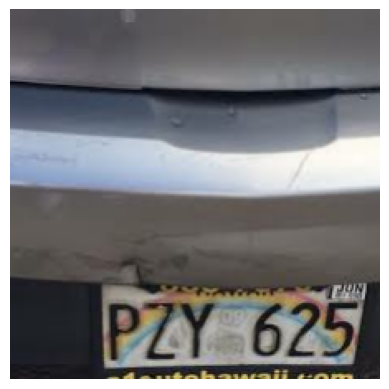

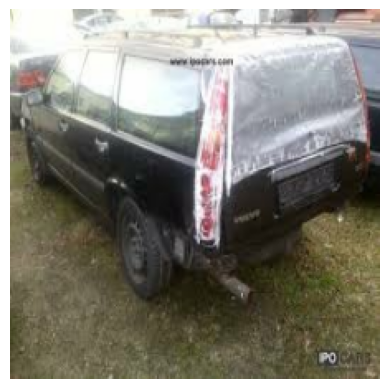

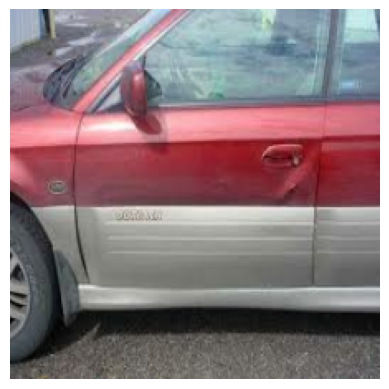

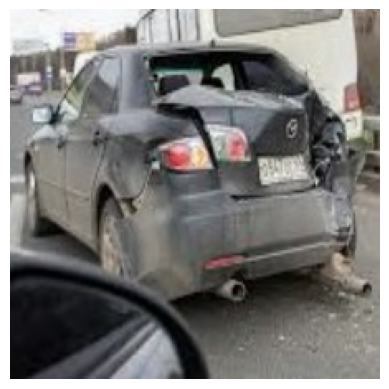

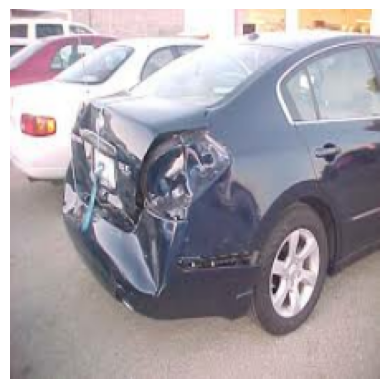

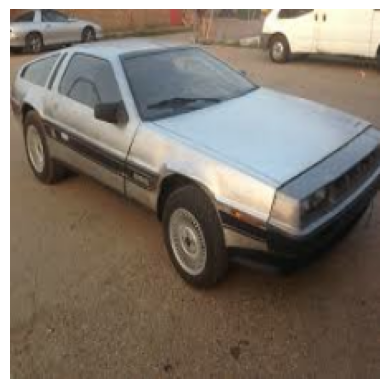

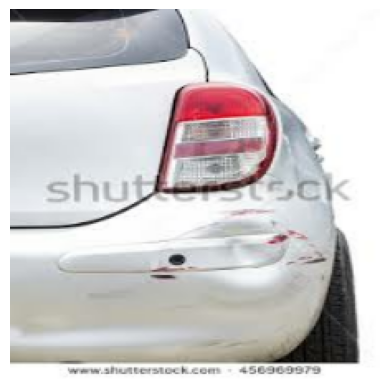

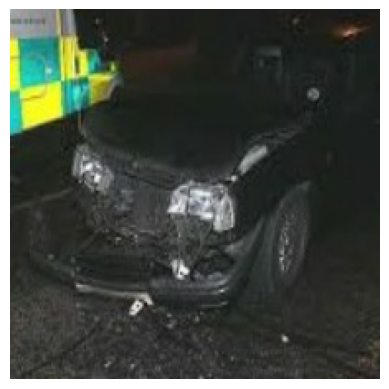

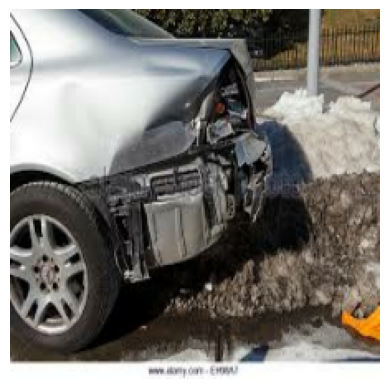

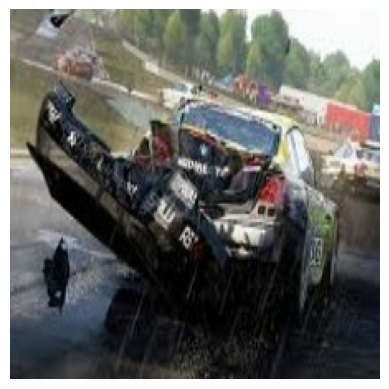

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Fungsi untuk menampilkan gambar
def show_image(image):
    # Konversi gambar tensor ke numpy array dan tampilkan dengan matplotlib
    image = image.numpy()  # Ubah tensor menjadi numpy array
    plt.imshow(image)
    plt.axis('off')  # Nonaktifkan axis
    plt.show()

# Fungsi untuk menampilkan beberapa gambar
def show_images_from_dataset(dataset, num_images=5):
    for i, data in enumerate(dataset.take(num_images)):  # Ambil beberapa gambar pertama dari dataset
        image = data['image']
        # Tampilkan gambar
        show_image(image)

# Menampilkan gambar pertama dari ds_train
show_images_from_dataset(ds_train, num_images=10)

## Loading The Dataset And Data Augmentation


In [10]:
# Memuat dataset yang sudah diproses
ds_train = tfds.load('car_damage_severity_dataset', split='train', data_dir=datasets_path)
ds_val = tfds.load('car_damage_severity_dataset', split='val', data_dir=datasets_path)
ds_test = tfds.load('car_damage_severity_dataset', split='test', data_dir=datasets_path)

In [11]:
def augment_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Menambahkan random zoom
    scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_height = tf.cast(scale * 224, tf.int32)
    new_width = tf.cast(scale * 224, tf.int32)
    image = tf.image.resize(image, (new_height, new_width))
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)  # Mengembalikan ke ukuran 224x224
    
    return image, label

## mobilenet

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Function to ensure data is paired as (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

# Apply preprocessing and augmentation
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
ds_train = ds_train.batch(16).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(16).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(16).prefetch(tf.data.AUTOTUNE)


## Restnet

In [22]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to ensure data is paired as (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    image = preprocess_input(image)
    return image, label

# Apply preprocessing and augmentation
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
ds_train = ds_train.batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
# Hitung jumlah data dalam ds_train
num_samples = sum(1 for _ in ds_train)
# num_samples = sum(1 for _ in ds_train.unbatch())

print(f"Jumlah gambar dan label dalam ds_train: {num_samples}")

Jumlah gambar dan label dalam ds_train: 62


## Creating The Model

### Tanpa Transfer Learning

In [69]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Menentukan input layer
input_layer = Input(shape=(224, 224, 3))

# Menambahkan beberapa lapisan konvolusi dan pooling
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x) 
x = Dense(512, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)  

# Membuat model akhir
model = Model(inputs=input_layer, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) 
# # Compiling the model 
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Dengan Transfer Learning

In [14]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(128, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Sigmoid untuk binary classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Compiling the model 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## MBNET 2

In [53]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  # ReLU activation setelah batch normalization
x = Dropout(0.55)(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Sigmoid untuk binary classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Compiling the model 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Show Model Architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 167,171 (653.01 KB)

 Non-trainable params: 2,255,680 (8.60 MB)

In [16]:
for image, label in ds_train.take(1):
    print(image.shape, label.shape)  # Pastikan gambar memiliki shape (32, 224, 224, 3)

(16, 224, 224, 3) (16, 3)


## Callbacks

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss',                  
    patience=5,                         
    restore_best_weights=True,           
    verbose=1                            
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',                
    factor=0.5,                         
    patience=3,                         
    verbose=1                           
)

## Train Model (Mobilenet)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.3761 - loss: 3.8035 - val_accuracy: 0.5031 - val_loss: 3.3055 - learning_rate: 0.0010
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.5293 - loss: 3.3382 - val_accuracy: 0.5153 - val_loss: 3.2341 - learning_rate: 0.0010
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.5975 - loss: 3.1469 - val_accuracy: 0.5245 - val_loss: 3.1700 - learning_rate: 0.0010
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.5676 - loss: 3.1402 - val_accuracy: 0.5521 - val_loss: 3.1104 - learning_rate: 0.0010
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.6116 - loss: 3.0242 - val_accuracy: 0.5583 - val_loss: 3.0113 - learning_rate: 0.0010
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.6596 - loss: 2.8764 - val_accuracy: 0.5460 - val_loss: 3.0077 - learning_rate: 0.0010
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.6503 - loss: 2.8

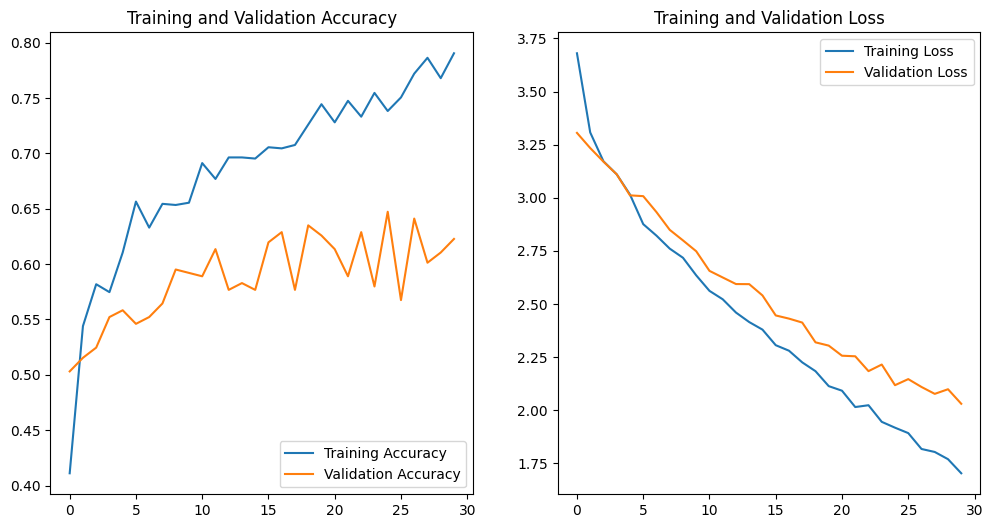

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5785 - loss: 2.0379
Testing Loss: 1.9735331535339355, Testing Accuracy: 0.6116207838058472


In [18]:
# class_weight = {0: 0.6 , 1: 1.2 , 2: 0.6}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    # class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler] 
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')

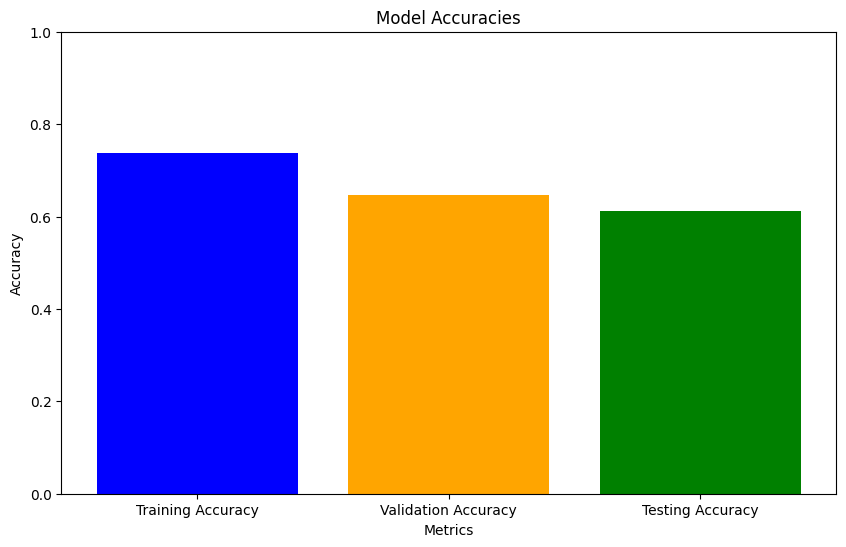

In [19]:
# Ambil nilai akurasi pada epoch terbaik
best_epoch = np.argmax(history.history['val_accuracy'])

train_accuracy = history.history['accuracy'][best_epoch] 
val_accuracy = history.history['val_accuracy'][best_epoch]

# Akurasi data testing (sudah didapat dari evaluasi model sebelumnya)
test_accuracy = accuracy

# Buat bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Atur batas y dari 0 sampai 1
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step


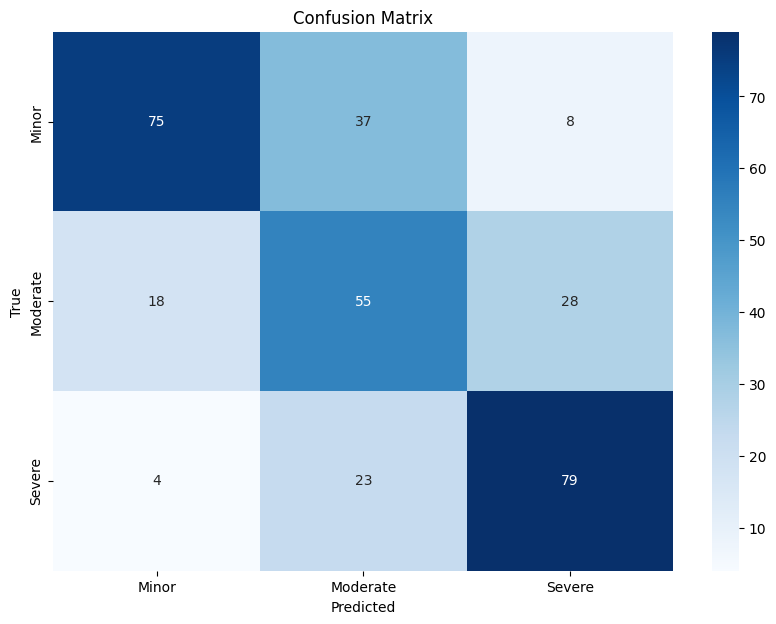

              precision    recall  f1-score   support

       Minor       0.77      0.62      0.69       120
    Moderate       0.48      0.54      0.51       101
      Severe       0.69      0.75      0.71       106

    accuracy                           0.64       327
   macro avg       0.65      0.64      0.64       327
weighted avg       0.65      0.64      0.64       327



In [20]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true_classes, y_pred_classes, target_names=['Minor', 'Moderate', 'Severe']))

In [21]:
# Saving the model in .h5 format
model.save('D:/Datasets/riset_infor_dataset/model_dataset/damage_detection_mobilenet.keras')

In [50]:
import tensorflow as tf

# Load model dari file .keras
model = tf.keras.models.load_model('D:/Datasets/riset_infor_dataset/model_dataset/damage_detection_mobilenet.keras')

# Buat converter untuk mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('D:/Datasets/riset_infor_dataset/model_dataset/damage_detection_mobilenet.tensor', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmp6l0vxq7j\assets


INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmp6l0vxq7j\assets


Saved artifact at 'C:\Users\albia\AppData\Local\Temp\tmp6l0vxq7j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2427129306400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129890416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129892528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129312208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129314496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129896400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129901152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129902912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129897456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427129900800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2427

## Mobilenet V2

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 982ms/step - accuracy: 0.3917 - loss: 3.8691 - val_accuracy: 0.4739 - val_loss: 3.5438 - learning_rate: 0.0010
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 915ms/step - accuracy: 0.4666 - loss: 3.6289 - val_accuracy: 0.5261 - val_loss: 3.4632 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 926ms/step - accuracy: 0.4995 - loss: 3.5180 - val_accuracy: 0.5226 - val_loss: 3.3717 - learning_rate: 0.0010
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 915ms/step - accuracy: 0.5324 - loss: 3.3789 - val_accuracy: 0.5401 - val_loss: 3.2723 - learning_rate: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 911ms/step - accuracy: 0.5554 - loss: 3.3383 - val_accuracy: 0.5505 - val_loss: 3.3061 - learning_rate: 0.0010
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 913ms/step - accuracy: 0.5638 - loss: 3.2763 - val_accuracy: 0.5505 - val_loss: 3.2452 - learning_rate: 0.0010
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5685 - loss: 3.261

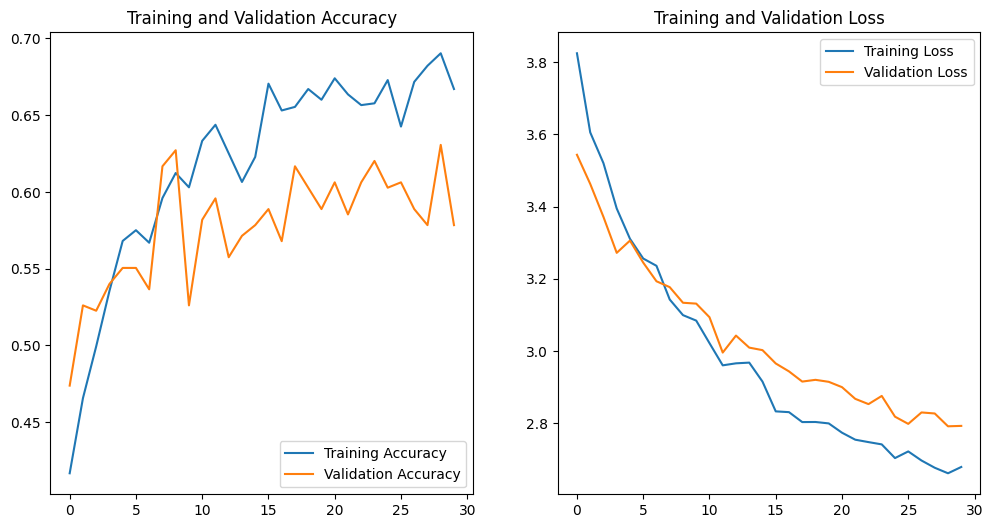

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 701ms/step - accuracy: 0.5858 - loss: 2.7865
Testing Loss: 2.7685935497283936, Testing Accuracy: 0.6097561120986938


In [27]:
# class_weight = {0: 0.6 , 1: 1.2 , 2: 0.6}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    # class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler] 
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')

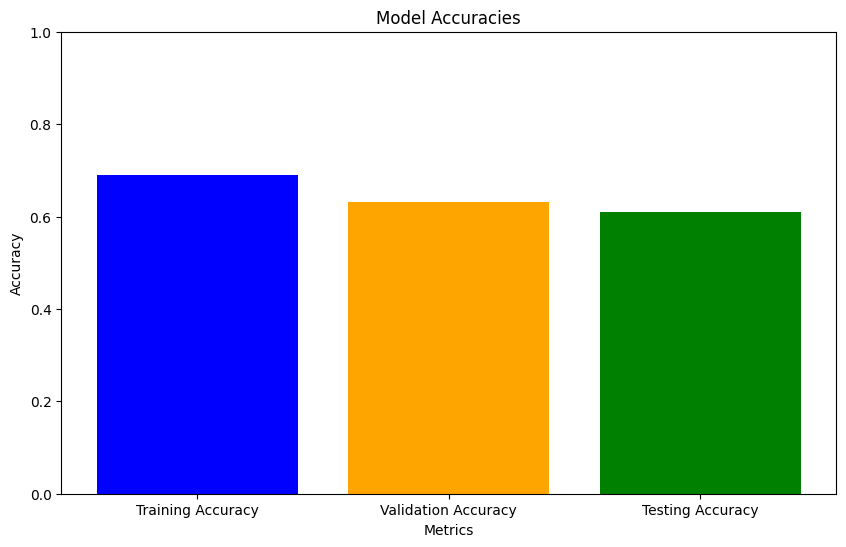

In [28]:
# Ambil nilai akurasi pada epoch terbaik
best_epoch = np.argmax(history.history['val_accuracy'])

train_accuracy = history.history['accuracy'][best_epoch] 
val_accuracy = history.history['val_accuracy'][best_epoch]

# Akurasi data testing (sudah didapat dari evaluasi model sebelumnya)
test_accuracy = accuracy

# Buat bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Atur batas y dari 0 sampai 1
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 835ms/step


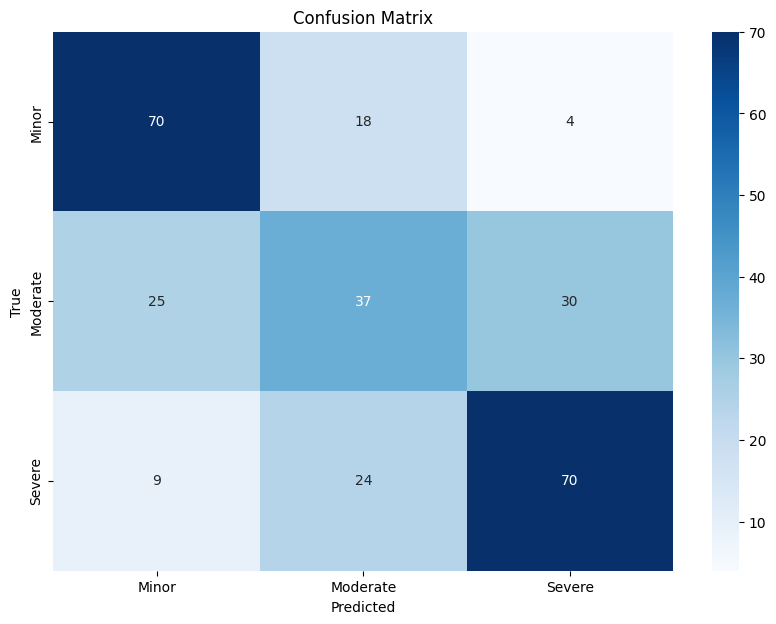

              precision    recall  f1-score   support

       Minor       0.67      0.76      0.71        92
    Moderate       0.47      0.40      0.43        92
      Severe       0.67      0.68      0.68       103

    accuracy                           0.62       287
   macro avg       0.60      0.61      0.61       287
weighted avg       0.61      0.62      0.61       287



In [29]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true_classes, y_pred_classes, target_names=['Minor', 'Moderate', 'Severe']))

In [30]:
# Saving the model in .h5 format
model.save('D:/Datasets/riset_infor_dataset/model_dataset/damage_detection_restnet.keras')

In [31]:
import tensorflow as tf

# Load model dari file .keras
model = tf.keras.models.load_model('D:/Datasets/riset_infor_dataset/model_dataset/damage_detection_restnet.keras')

# Buat converter untuk mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('D:/Datasets/riset_infor_dataset/model_dataset/damage_detection_restnet.tensor', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmpj9nog14_\assets


INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmpj9nog14_\assets


Saved artifact at 'C:\Users\albia\AppData\Local\Temp\tmpj9nog14_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2599558973920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558978848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558986768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558987840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558982192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558984480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558994704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558988720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599558995232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599559001920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2599